<a href="https://colab.research.google.com/github/S-VATS31/Deep_Learning_Models/blob/main/Vats_Positional_Encoding_and_Layer_Normalization_and_Multi_Headed_Attention_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [193]:
import math
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# **Sinusoidal Positional Encodings**

In [194]:
class PositionalEncoding(torch.nn.Module):
    def __init__(self, T, d_model):
        super(PositionalEncoding, self).__init__()
        """Initialize sinusoidal positional encoding layer.

        Generates fixed positional encodings using sine and cosine functions to provide
        position information for sequences in transformer models. Encodings are computed
        for a fixed sequence length and stored as a non-learnable buffer meaning it is
        not passed through backpropagation.

        Args:
            T (int): Maximum sequence length (number of tokens).
            d_model (int): Dimensionality of the model's input/output representations.
                Must be even for sine/cosine splitting.

        Attributes:
            PE (torch.Tensor): Positional encoding tensor of shape (T, d_model),
                registered as a buffer (non-learnable).
        """

        # Create position indices
        position = torch.arange(0, T).unsqueeze(1).float() # [T, 1]

        # Compute denominator of Sinusoidal Positional Encoding algorithm
        divisor = torch.exp(torch.arange(0, d_model, 2).float() * - (math.log(10000.0) / d_model)) # [d_model//2]

        # Create Sine and Cosine encodings
        PE = torch.zeros(T, d_model) # [T, d_model]

        PE[:, 0::2] = torch.sin(position * divisor) # Even indices --> Sine (2i)
        PE[:, 1::2] = torch.cos(position * divisor) # Odd indices --> Cosine (2i+1)

        # Register encodings as a buffer rather being a learned/updated parameter
        self.register_buffer('PE', PE)

    def forward(self, x):
        """Apply sinusoidal positional encodings to the input tensor.

        Adds precomputed positional encodings to the input tensor to incorporate
        positional information.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len, d_model).

        Returns:
            torch.Tensor: Input tensor with positional encodings added, using element-wise addition.
        """
        return x + self.PE[:x.size(1), :]

# **Graph Sinusoidal Positional Encodings**

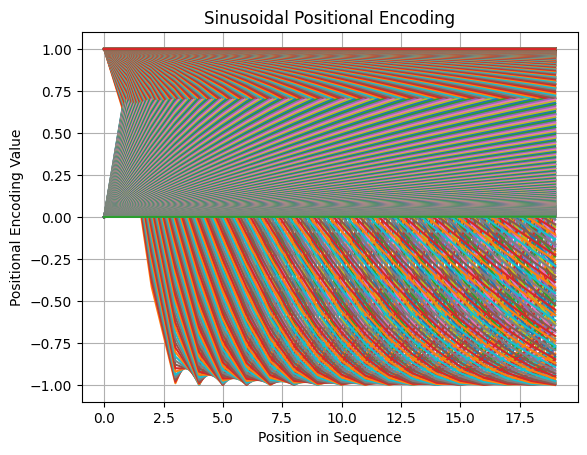

In [195]:
def graph_PE(T, d_model):
    """Generate sinusoidal positional encodings for visualization.

    Computes positional encodings using sine and cosine functions for a given sequence
    length and model dimensionality. Returns a tensor meant for plotting to visualize
    positional encoding patterns.

    Args:
        T (int): Sequence length (number of tokens).
        d_model (int): Dimensionality of the model's representations. Must be even
            for sine/cosine splitting.

    Returns:
        torch.Tensor: Positional encoding tensor of shape (T, d_model), with sine
            values at even indices and cosine values at odd indices.
    """
    # Create position indices
    position = torch.arange(0, T).unsqueeze(1).float() # [T, 1]

    # Compute denominator of Sinusoidal Positional Encoding algorithm
    divisor = torch.exp(torch.arange(0, d_model, 2).float() * - (math.log(10000.0) / d_model)) # [d_model//2]

    # Create Sine and Cosine encodings
    PE = torch.zeros(T, d_model) # [T, d_model]

    PE[:, 0::2] = torch.sin(position * divisor) # Even indices --> Sine (2i)
    PE[:, 1::2] = torch.cos(position * divisor) # Odd indices --> Cosine (2i+1)

    return PE

T = 20
d_model = 1024

# Call graphing function
PE = graph_PE(T, d_model)

# Graph PE
plt.plot(PE)
plt.title("Sinusoidal Positional Encoding")
plt.xlabel("Position in Sequence")
plt.ylabel("Positional Encoding Value")
plt.grid(True)
plt.show()

# **Layer Normalization**

In [196]:
class LayerNorm(torch.nn.Module):
    def __init__(self, normalized_shape, eps=1e-6, dtype=torch.float32):
        """Initialize Layer Normalization module.

        Layer Normalization normalizes the input tensor over the last dimension, stabilizing training by
        reducing internal covariate shift. It applies learnable scaling (gamma) and shifting (beta) parameters
        to the normalized tensor.

        Args:
            normalized_shape (torch.Tensor): Shape of the input tensor's normalized dimension(s).
                For example, if the input is (batch, seq_len, features), this would be `features` or
                a tuple of the last dimensions.
            eps (float, optional): Small constant added to the variance to prevent division by zero.
                Defaults to 1e-6.
            dtype (torch.dtype, optional): Data type for the learnable parameters. Defaults to torch.float32.

        Attributes:
            gamma (torch.nn.Parameter): Learnable scaling factor, initialized to ones.
            beta (torch.nn.Parameter): Learnable shift factor, initialized to zeros.
            eps (float): Small constant for numerical stability.
        """
        super(LayerNorm, self).__init__()
        self.eps = eps
        self.gamma = torch.nn.Parameter(torch.ones(normalized_shape, dtype=dtype))
        self.beta = torch.nn.Parameter(torch.zeros(normalized_shape, dtype=dtype))

    def forward(self, x):
        """Perform Layer Normalization on the input tensor.

        Normalizes the input tensor over the last dimension by subtracting the mean and dividing by the
        standard deviation, then applies learnable scaling (gamma) and shifting (beta).

        Args:
            x (torch.Tensor): Input tensor of shape (..., normalized_shape).

        Returns:
            torch.Tensor: Normalized and transformed tensor of the same shape as the input,
                computed as `gamma * normalized_x + beta`.
        """
        mean = x.mean(dim=-1, keepdim=True) # Compute mean over the last dimension
        var = x.var(dim=-1, unbiased=False, keepdim=True) # Compute variance over the last dimension
        normalized_x = (x - mean) / torch.sqrt(var + self.eps) # Normalize the input
        return self.gamma * normalized_x + self.beta # Apply scaling and shifting

# **Multi Headed Attention Based on Original Transformer**

In [197]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(self, T, B, d_model, num_heads, dropout=0.1):
        """Initialize Multi-Head Attention module.

        Implements multi-head self-attention mechanism for transformer models, allowing the model
        to focus on different parts of the input sequence simultaneously. Includes positional
        encoding, layer normalization, and dropout for regularization.

        Args:
            T (int): Maximum sequence length (number of tokens).
            B (int): Batch size.
            d_model (int): Dimensionality of the model's input/output representations.
                Must be divisible by num_heads.
            num_heads (int): Number of attention heads.
            dropout (float, optional): Dropout probability for attention weights and output.
                Defaults to 0.1.

        Attributes:
            d_k (int): Dimensionality of each attention head (d_model // num_heads).
            W_Q (torch.nn.Linear): Linear projection for queries.
            W_K (torch.nn.Linear): Linear projection for keys.
            W_V (torch.nn.Linear): Linear projection for values.
            W_O (torch.nn.Linear): Linear projection for output.
            positional_encoding (PositionalEncoding): Positional encoding layer.
            dropout (torch.nn.Dropout): Dropout layer for regularization.
            layer_norm (LayerNorm): Layer normalization module.
        """
        super(MultiHeadAttention, self).__init__()
        self.T = T
        self.B = B
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        # Weight Matrices
        self.W_Q = torch.nn.Linear(d_model, d_model)
        self.W_K = torch.nn.Linear(d_model, d_model)
        self.W_V = torch.nn.Linear(d_model, d_model)
        self.W_O = torch.nn.Linear(d_model, d_model)

        self.positional_encoding = PositionalEncoding(T, d_model)
        self.dropout = torch.nn.Dropout(p=dropout)
        self.layer_norm = LayerNorm(d_model)

    def forward(self, x, mask=None):
        """Apply multi-head attention to the input tensor.

        Computes scaled dot-product attention for multiple heads, incorporating positional
        encodings, layer normalization, and optional padding masks. Returns the attention
        output and attention weights.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len, d_model).
            mask (torch.Tensor, optional): Padding mask of shape (batch_size, seq_len).
                Zeros indicate padded positions; ones indicate valid positions.
                Defaults to None.

        Returns:
            tuple:
                - torch.Tensor: Attention output of shape (batch_size, seq_len, d_model).
                - torch.Tensor: Attention weights of shape (batch_size, num_heads, seq_len, seq_len).
        """
        residual = x # Residual connection
        x = self.layer_norm(x) # Apply LayerNorm

        # Apply Positional Encoding
        x = self.positional_encoding(x)

        # Linear projections
        Q = self.W_Q(x) # Query: [B, T, d_model]
        K = self.W_K(x) # Key: [B, T, d_model]
        V = self.W_V(x) # Value: [B, T, d_model]

        # Reshape for multi-head attention
        Q = Q.view(self.B, self.T, self.num_heads, self.d_k).transpose(1, 2) # [B, num_heads, T, d_k]
        K = K.view(self.B, self.T, self.num_heads, self.d_k).transpose(1, 2) # [B, num_heads, T, d_k]
        V = V.view(self.B, self.T, self.num_heads, self.d_k).transpose(1, 2) # [B, num_heads, T, d_k]

        # Scaled Dot Product Attention
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k) # [B, num_heads, T, T]

        # Apply padding mask if provided
        if mask is not None:
            mask = mask.unsqueeze(1).unsqueeze(2) # [B, 1, 1, T]
            attention_scores = attention_scores.masked_fill(mask == 0, float('-inf')) # Mask padded positions

        attention_weights = F.softmax(attention_scores, dim=-1) # [B, num_heads, T, T]
        attention_weights = self.dropout(attention_weights)

        attention_output = torch.matmul(attention_weights, V) # [B, num_heads, T, d_k]

        # Concatenate the attention heads and apply final projection
        attention_output = attention_output.transpose(1, 2).contiguous().view(self.B, self.T, self.d_model) # [B, T, d_model]
        attention_output = self.dropout(attention_output)
        attention_output = self.W_O(attention_output) # Final output projection

        # Apply residual connection
        final_output = attention_output + residual
        return final_output, attention_weights

T = 20 # Number of tokens
B = 64 # Batch size
d_model = 1024 # Dimensionality of the model's input/output
num_heads = 16 # Number of attention heads

# Initialize Multi-Head Attention
MHA = MultiHeadAttention(T, B, d_model, num_heads)

# Random input tensor (B, T, d_model)
x = torch.randn(B, T, d_model)

# Optional padding mask
mask = torch.ones(B, T) # No padding

# Forward pass
output, attention_weights = MHA(x, mask)

print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {attention_weights.shape}")


Input shape: torch.Size([64, 20, 1024])
Output shape: torch.Size([64, 20, 1024])
Attention weights shape: torch.Size([64, 16, 20, 20])


# **Number of Parameters**

In [198]:
# Check total parameters
total_params = sum(p.numel() for p in MHA.parameters())
print(f"Total parameters: {total_params}")

# Check trainable parameters
trainable_params = sum(p.numel() for p in MHA.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

Total parameters: 4200448
Trainable parameters: 4200448
